# Price Elasticity Model

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [656]:
# Load the cleaned dataset 
df=pd.read_excel("edaoutput.xlsx",index_col=0)

In [657]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3271 entries, 0 to 3270
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   ActivitySiteID                           3271 non-null   object        
 1   BookingEndDateTime (Month / Day / Year)  3271 non-null   datetime64[ns]
 2   BookingStartTime                         3271 non-null   object        
 3   MaxBookees                               3271 non-null   float64       
 4   Number Booked                            3271 non-null   int64         
 5   Price (INR)                              3271 non-null   int64         
 6   ActivityDescription_clean                3271 non-null   object        
 7   Price_log                                3271 non-null   float64       
 8   NumberBooked_log                         3271 non-null   float64       
 9   Price_Tier                               3271 

## Build the Price Elasticity Model 

In [659]:
#data preparation
df['NumberBooked_log'] = np.log1p(df['Number Booked'])
df['Price_log'] = np.log1p(df['Price (INR)'])
df['Fill_Rate_squared'] = df['Fill_Rate']**2
df['Price_log_squared'] = df['Price_log']**2
df['MaxBookees_squared'] = df['MaxBookees']**2

In [663]:
# Handle categorical variables using One-Hot Encoding
df = pd.get_dummies(df, columns=['Booking_Weekday', 'Price_Tier'], drop_first=True,dtype="int")

# Define your dependent (y) and independent (X) variables
y = df['NumberBooked_log']

# Ensure X columns match your previous model, including newly created dummies.

X_cols = [
    'Price_log', 'Price_log_squared',
    'MaxBookees', 'MaxBookees_squared',
    'Fill_Rate', 'Fill_Rate_squared'
]
# Add dummy variables if they exist in the DataFrame
for col in df.columns:
    if col.startswith('Booking_Weekday_') or col.startswith('Price_Tier_'):
        X_cols.append(col)

# Filter X_cols to only include columns that actually exist in df
X_cols_existing = [col for col in X_cols if col in df.columns]

X = df[X_cols_existing]

# Add a constant (intercept) to the independent variables for StatsModels
X = sm.add_constant(X)

# --- Step 1: Perform Train-Test Split ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

Training set size: 1962 samples
Test set size: 1309 samples


In [665]:
# --- Step 2: Build and Fit the OLS Model on the Training Data ---
print("\n--- Fitting OLS Model on Training Data ---")
model_trained = sm.OLS(y_train, X_train).fit()
print(model_trained.summary())

# --- Step 3: Make Predictions on the Test Data ---
y_pred_test = model_trained.predict(X_test)

# --- Step 4: Evaluate Model Performance on the Test Data ---
print("\n--- Model Evaluation on Test Data ---")

# R-squared on test set
test_r_squared = r2_score(y_test, y_pred_test)
print(f"Test R-squared: {test_r_squared:.4f}")

# Mean Squared Error (MSE) on test set
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Test Mean Squared Error (MSE): {test_mse:.4f}")

# Root Mean Squared Error (RMSE) on test set
test_rmse = np.sqrt(test_mse)
print(f"Test Root Mean Squared Error (RMSE): {test_rmse:.4f}")


--- Fitting OLS Model on Training Data ---
                            OLS Regression Results                            
Dep. Variable:       NumberBooked_log   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     2997.
Date:                Wed, 16 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:59:28   Log-Likelihood:                 1099.9
No. Observations:                1962   AIC:                            -2170.
Df Residuals:                    1947   BIC:                            -2086.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

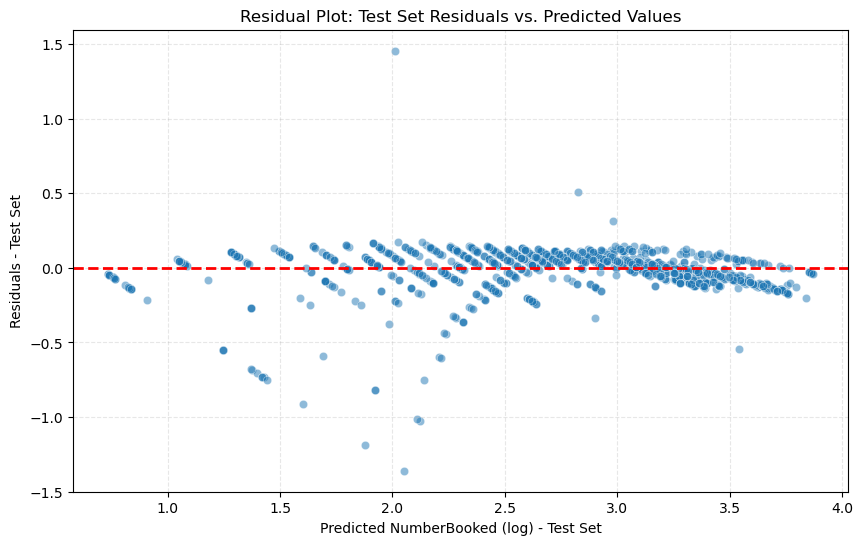

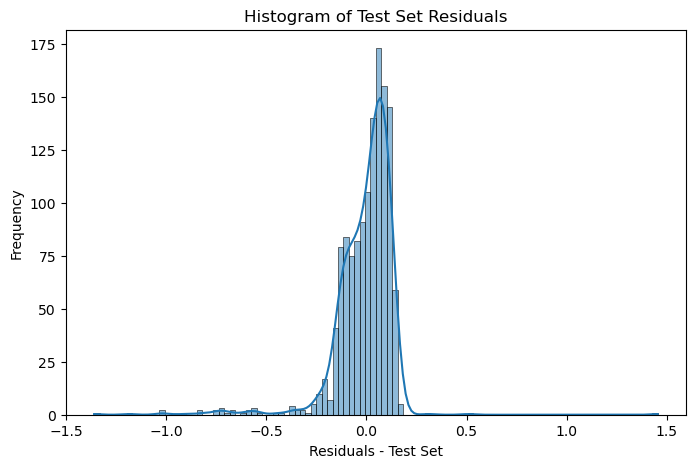


Train-test split and evaluation complete.


In [667]:
# --- Step 5: Visualize Residuals for the Test Set ---
# Create residual plot for test set predictions
test_residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=test_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted NumberBooked (log) - Test Set')
plt.ylabel('Residuals - Test Set')
plt.title('Residual Plot: Test Set Residuals vs. Predicted Values')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# Histogram of Residuals for test set
plt.figure(figsize=(8, 5))
sns.histplot(test_residuals, kde=True)
plt.xlabel('Residuals - Test Set')
plt.ylabel('Frequency')
plt.title('Histogram of Test Set Residuals')
plt.show()

print("\nTrain-test split and evaluation complete.")

Objective: Analyze price elasticity and key drivers of customer bookings

Model Type: OLS regression with nonlinear (squared) terms

Train R²: 0.956

Test R²: 0.954

Test RMSE: 0.1483 (log scale)

Price_log and Price_log_squared are not statistically significant

MaxBookees and Fill_Rate are strong positive predictors

MaxBookees_squared and Fill_Rate_squared show diminishing returns

Weekday variables (Monday to Wednesday) have minor but significant effects

Price tiers (Low, Medium) are not significant after controlling for other features

Model has excellent predictive accuracy and no overfitting

Residuals are not normally distributed, but performance is unaffected

Multicollinearity is manageable; no major issues impacting model stability

Model is suitable for predicting bookings and identifying operational levers like capacity and fill rate